## Preliminary Code for Tutorial

In [2]:
#@title

#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""This module serves to implement necessary code to simulate
diffusion.

This module has functions for displaying simulations.
"""

from math import pi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               FuncFormatter)
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# Hard coded value for simulation limits and figure size
graph_lim = 10
figsize = (14, 7)


def display_atom(atom_prev_states, show_displacement=False):
    """Shows the position of an atom in a square lattice.

    Optionally show the atom position 'crumb trail' as well as
    display the displacment of the atom versus number of jumps.

    Parameters
    ----------
    atom : list
        x,y coordinate of atom in the lattice.

    show_displacement : boolean
        Include the plot show displacement of atom. Defaults to False.
    """

    # Create main figure and axis for atom plot
    fig = plt.figure(figsize=figsize)
    ax_atom = fig.add_subplot('121')

    # Check whether atom is a single coordinate or a list including
    # previous positions
    if isinstance(atom_prev_states[0], int):
        # Place atom on the square lattice
        x_final, y_final = atom_prev_states
        ax_atom.scatter(x=x_final, y=y_final, c='blue', zorder=4)
    else:
        # Draw atom previous position, incuding final atom position
        x_final, y_final = atom_prev_states[-1]
        draw_atom_prev_states(ax_atom, atom_prev_states)

    # Add in arrow to highlight atom position
    ax_atom.arrow(x=0, y=0, dx=x_final, dy=y_final, width=0.2,
                  length_includes_head=True, color='purple', zorder=5)

    # Display final displacement of atom as text.
    disp = displacement([x_final, y_final])
    draw_box(ax_atom, "Displacement", disp)

    ax_atom.set_xlabel("Simulated Atom Position and Trajectory", labelpad=20)

    set_ticks(ax_atom)
    set_equal_aspect(ax_atom)
    draw_lattice_atoms(ax_atom)

    # Check whether to plot atom displacement
    if show_displacement:
        ax_disp = fig.add_subplot('122')

        # Draw and format
        draw_disp_history(ax_disp, atom_prev_states)
        ax_disp.set_ylabel("Displacement")
        ax_disp.set_xlabel("Number of Simulaton Steps", labelpad=20)

        # Ensure that the axes look square
        set_equal_aspect(ax_disp)

    # Display the atom on the square lattice
    plt.show()


def display_atoms(atoms_prev_states):
    """Shows the position of various atoms in a square lattice.

    Overlays the resulting simulation of various atoms and their
    positions. The displacement vs. simulation time graph is included
    displaying each atom displacement history as well at the average.

    Parameters
    ----------
    atoms_prev_states : list
        The position history of various atoms as stored list of lists.
    """

    n_atoms = len(atoms_prev_states)
    m_steps = len(atoms_prev_states[0])
    mean_disp_history = [0]*m_steps

    fig, (ax_atoms, ax_disps) = plt.subplots(1, 2, figsize=figsize)

    # Iterate through all atoms simulations
    for atom_prev_states in atoms_prev_states:
        # Draw atom trajectory and displacement
        draw_atom_prev_states(ax_atoms, atom_prev_states, n_atoms)
        draw_disp_history(ax_disps, atom_prev_states, n_atoms)

        # Calculate the average displacement for the simulation
        # Append to list for plotting
        disp_history = calc_disp_history(atom_prev_states)
        for i, disp in enumerate(disp_history):
            mean_disp_history[i] += disp/n_atoms

    # Set axis label
    ax_atoms.set_xlabel("Simulated Atom Positions and Trajectories", labelpad=20)
    ax_disps.set_ylabel("Displacement")
    ax_disps.set_xlabel("Number of Simulaton Steps", labelpad=20)

    # Plot average of all trajectory displacements
    ax_disps.plot(mean_disp_history, c='purple', linewidth=5)

    # Include average final displacement of atoms
    draw_box(ax_atoms, "Mean Displacement", mean_disp_history[-1])

    # Draw square lattice atoms
    draw_lattice_atoms(ax_atoms)
    set_ticks(ax_atoms)

    # Make plots square
    set_equal_aspect(ax_atoms)
    set_equal_aspect(ax_disps)

    # Display the atom on the square lattice
    plt.show()


def display_probability(atoms_prev_states, show_gaussian=False):
    """Shows the final position of simulated atoms normalized by the
    number of atoms.

    Equivalent to probability. Option to show the theoretical,
    continuous gaussian distribution of final atom positions.

    Parameters
    ----------
    atoms_prev_states : list
        The position history of various atoms as stored list of lists.

    show_gaussian : bool
        Display the theoretical atom distribution. Defaults to False.
    """

    fig = plt.figure(figsize=(14, 7))
    ax_atoms = fig.add_subplot(121)

    # Since the there's 1 jump per timestep, steps equals jumps
    num_jumps = len(atoms_prev_states[0])
    m_steps = len(atoms_prev_states[0])

    # Get final position of atoms and unpack as x,y values
    atoms_final = [atom_prev_states[-1] for atom_prev_states in atoms_prev_states]
    x_finals, y_finals = zip(*atoms_final)

    # Create the estimated gaussian distribution
    draw_atoms_histogram(ax_atoms, x_finals, y_finals)

    ax_atoms.set_xlabel("Percentage of Atoms at a Given Position After " \
                        "m Simulation Steps", labelpad=20)

    # Make plots square, adjust ticks, add in colorbars
    draw_lattice_atoms(ax_atoms)
    set_equal_aspect(ax_atoms)
    set_ticks(ax_atoms)

    if show_gaussian:
        # Add in axis for gaussian distribution
        ax_gauss = fig.add_subplot(122)

        # Set distribution mean and standard deviation
        mean = 0
        std_dev = (num_jumps/3)**0.5 * 1

        # Draw the historgram for true gaussian distribution
        draw_theoretical_histogram(ax_gauss, mean, std_dev, m_steps)

        ax_gauss.set_xlabel("Exact Atom Position Probability After m " \
                            "Simulation Steps", labelpad=20)

        draw_lattice_atoms(ax_gauss)
        set_equal_aspect(ax_gauss)
        set_ticks(ax_gauss)

    plt.show()


def draw_lattice_atoms(ax):
    """Draw circle representing a lattice atom at every grid point,
    shifting by half a unit such that the diffusing atom resides at
    the grid point instead."""

    # Iterate through between the graph limits, shifted by half a unit
    for x in np.linspace(-graph_lim+0.5, graph_lim-0.5, 2*graph_lim):
        for y in np.linspace(-graph_lim+0.5, graph_lim-0.5, 2*graph_lim):
            # Make circle and add it to the graph axis
            lattice_circle = plt.Circle((x, y), 0.5, fill=False, edgecolor='gray')
            ax.add_artist(lattice_circle)


def draw_atom_prev_states(ax, atom_prev_states, n_atoms=1):
    """Draw the atom's previous path from starting point to endpoint.
    If there are several atoms to be drawn, transparency is added."""

    # Get final atom endpoint and previous path as xy coordinates
    x_final, y_final = atom_prev_states[-1]
    x_hist, y_hist = zip(*atom_prev_states)

    # If several atoms to draw, add transparency
    if n_atoms != 1:
        alpha_hist = 0.1
        alpha_final = 0.4
    else:
        alpha_hist = 1
        alpha_final = 1

    # Plot final position as point, and previous path as a line
    ax.plot(x_hist, y_hist, c='blue', alpha=alpha_hist)
    ax.scatter(x=x_final, y=y_final, alpha=alpha_final, c='blue')


def draw_disp_history(ax, atom_prev_states, n_atoms=1):
    """Draw the displacement of an atom path against the number of time
    steps/jumps."""

    # Calculate displacements based of previous positions
    disp_history = calc_disp_history(atom_prev_states)

    if n_atoms != 1:
        alpha = set_alpha(n_atoms)
    else:
        alpha = 1

    # Plot and format
    ax.plot(disp_history, alpha=alpha, c='purple', linewidth=2)


def set_equal_aspect(ax):
    """Adjust the graph axis so they're square."""
    x_lower, x_upper = ax.get_xlim()
    y_lower, y_upper = ax.get_ylim()
    ax.set_aspect((x_upper-x_lower)/(y_upper-y_lower))


def draw_box(ax, text, float_value):
    """Draw a text box in the upper righthand corner of the graph."""

    # Convert float to string
    value_str = "{0:.2f}".format(float_value)

    # Plot text in upper righthand corner. Ajust alignment, and
    # Make the text box background opaque white.
    ax.text(x=0.95, y=0.92,
            s=text + "=" + value_str,
            horizontalalignment='right', verticalalignment='center',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=1))


def set_ticks(ax):
    """Set graph x and y limits, add in grid lines, set the major axis
    tick values to be integers, and multiples of five."""


    # Set limits as defined at top of file
    ax.set_xlim([-graph_lim, graph_lim])
    ax.set_ylim([-graph_lim, graph_lim])

    # Add in gridlines
    ax.grid()

    # Make x and y axis major ticks multiples of 5
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(5))

    # Make x and y axis major tiock labels integers
    ax.yaxis.set_major_formatter(FormatStrFormatter('% d'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('% d'))

    # Turn off minor ticks
    ax.minorticks_off()


def calc_disp_history(atom_prev_states):
    """Calculate the equivalent displacment of an atom from the origin
    based on its previous path."""

    disp_history = []
    for xy in atom_prev_states:
        disp_history.append(displacement(xy))

    return disp_history


def displacement(xy):
    """Calculate the displacement based on x,y coordinate of the form
    [x, y]"""
    x = xy[0]
    y = xy[1]

    return (x**2 + y**2)**0.5


def set_alpha(x):
    """Function to increase transparency based on increasing input"""
    n = 5
    return n / (n+x)


def set_colorbar(ax, mesh):
    """Set the colorbar to be the same height as graph for 2D meshgrid"""

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Set tick format to be a percentage
    tick_func = lambda x,pos: "{:.0%}".format(x)
    tick_format = FuncFormatter(tick_func)

    plt.colorbar(mesh, cax=cax, format=tick_format)


def draw_atoms_histogram(ax_atoms, x_finals, y_finals):
    """Draw the count of atoms in a given position."""

    # Create 2D grid from historgram of
    _, _, _, color_mesh = ax_atoms.hist2d(
                            x_finals,
                            y_finals,
                            bins=2*graph_lim+1,
                            range=[[-graph_lim-0.5, graph_lim+0.5],
                                   [-graph_lim-0.5, graph_lim+0.5]],
                            density=True,
                            cmap=plt.get_cmap('Blues'))

    set_colorbar(ax_atoms, color_mesh)


def draw_theoretical_histogram(ax_gauss, mean, std_dev, m_steps):
    """Draw the true distribution of the probability of finding an atom
    at a given coordinate after m steps."""

    # Approximate continuous distribution with many grid points
    x_cont, y_cont = np.mgrid[-graph_lim-0.5:graph_lim+0.5:(2*graph_lim+2)*1j,
                              -graph_lim-0.5:graph_lim+0.5:(2*graph_lim+2)*1j]

    # Calculate gaussian mesh
    distance = np.sqrt(x_cont*x_cont+y_cont*y_cont)
    z_cont = np.exp(-((distance-mean)**2 / ( 2.0 * std_dev**2 )))
    z_cont *= 3 / (2 * pi * m_steps)

    gauss_mesh = ax_gauss.pcolormesh(x_cont, y_cont, z_cont,
                                     cmap=plt.get_cmap('Blues'))

    set_colorbar(ax_gauss, gauss_mesh)

## Tutorial Code Follow Along

In [ ]:
# Access some helpful tools
import random

In [ ]:
# Represent an atom using x,y coordinates, starting at the origin.
# For argument's sake say the length scale is just arbitrary/scaled units of '1'.
atom = [0, 0]

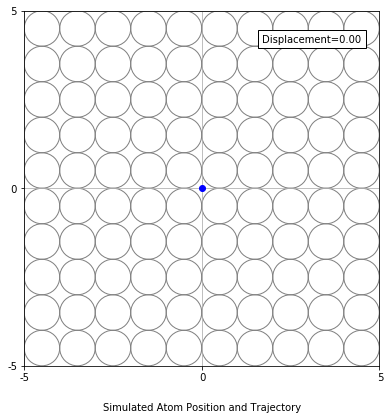

In [ ]:
# Display the position of the atom
display_atom(atom)

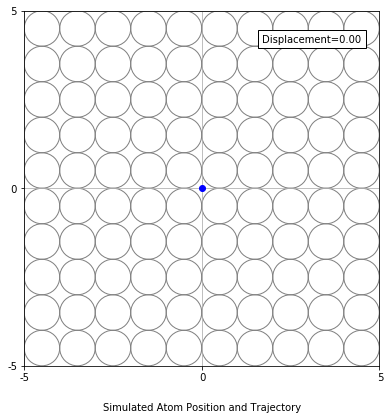

In [ ]:
# Make the atom 'walk' around the square lattice by randomly jumping

atom = [0, 0] 

# Define moving left or right randomly
atom[0] = atom[0] + random.randint(-1, 1)

# Define moving up or down randomly
atom[1] = atom[1] + random.randint(-1, 1)

display_atom(atom)

In [ ]:
def jump(atom):
    """Make the atom 'walk' around the square lattice by randomly jumping."""

    original_x, original_y = atom

    directions = ["Up", "Down", "Left", "Right"]
    random_direction = random.choice(directions)

    if random_direction == "Up":
        new_x = original_x
        new_y = original_y + 1

    if random_direction == "Down":
        new_x = original_x
        new_y = original_y - 1

    if random_direction == "Left":
        new_x = original_x - 1
        new_y = original_y

    if random_direction == "Right":
        new_x = original_x + 1
        new_y = original_y

    updated_atom = [new_x, new_y]

    return updated_atom

In [ ]:
def simulate_atom(m_steps):

    atom = [0, 0]
    atom_prev_states = []
    # disp_history = [displacement(atom)]

    for m in range(m_steps):
        atom_prev_states.append(atom)
        updated_atom = jump(atom)
        atom = updated_atom

    atom_prev_states.append(atom)

    return atom_prev_states

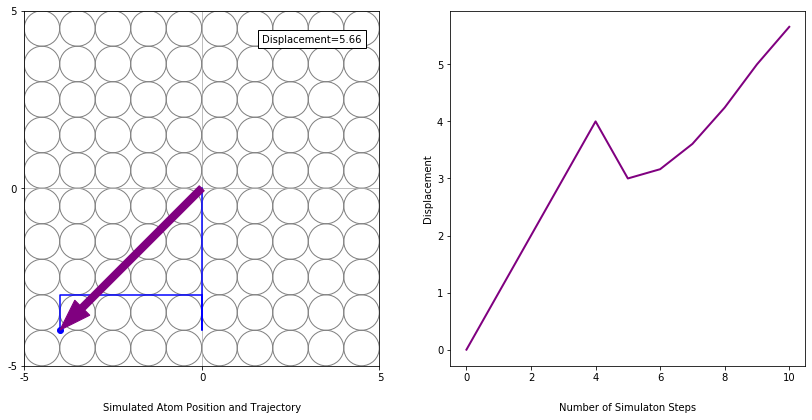

In [ ]:
atom_prev_states = simulate_atom(m_steps=10)
display_atom(atom_prev_states, show_displacement=True)

In [ ]:
def simulate_atoms(n_atoms, m_steps):

    atoms_prev_states = []

    for n in range(n_atoms):
        atom = [0, 0]
        atom_prev_states = simulate_atom(m_steps)
        atoms_prev_states.append(atom_prev_states)

    return atoms_prev_states

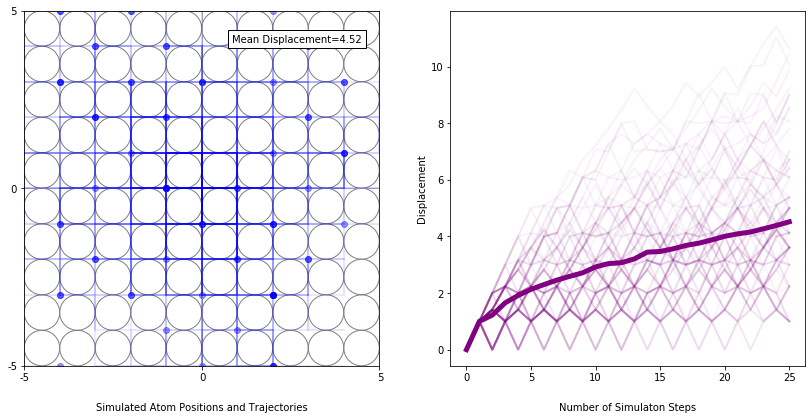

In [ ]:
atoms_prev_states = simulate_atoms(n_atoms=100, m_steps=25)
display_atoms(atoms_prev_states)

[-5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5 -5.5] [-5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5  5.5]


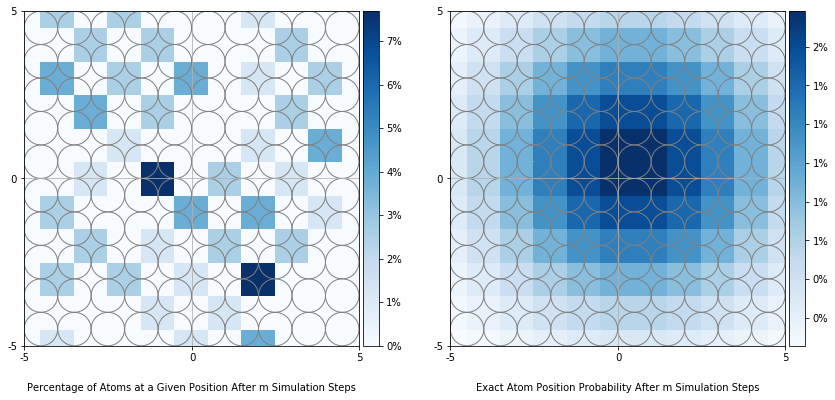

In [ ]:
display_probability(atoms_prev_states, show_gaussian=True)